In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
normal_path = 'OralCancer/Normal'
oscc_path = 'OralCancer/OSCC'

In [3]:
def load_images(folder_path, label, image_size=(128, 128)):
    images, labels = [], []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load Normal and OSCC images
normal_images, normal_labels = load_images(normal_path, label=0)
oscc_images, oscc_labels = load_images(oscc_path, label=1)

In [4]:
images = np.concatenate((normal_images, oscc_images), axis=0)
labels = np.concatenate((normal_labels, oscc_labels), axis=0)

In [5]:
# Normalize images
images = images / 255.0
# One-hot encode labels
labels = to_categorical(labels, num_classes=2)

In [6]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=97, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=97, stratify=y_temp)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LayerNormalization

# Define the KAN model
model = Sequential([
    # First Convolutional Block
    Conv2D(filters=8, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=(128, 128, 3)),
    LayerNormalization(),

    # Second Convolutional Block
    Conv2D(filters=16, kernel_size=5, strides=2, padding='valid', activation='relu'),
    LayerNormalization(),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected Layer (Dense)
    Dense(10, activation='relu'),

    # Output Layer (Softmax for binary classification)
    Dense(2, activation='softmax')  # Two units for multi-class classification
])

# Compile the model with categorical crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 8)         608       
                                                                 
 layer_normalization (Layer  (None, 62, 62, 8)         16        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        3216      
                                                                 
 layer_normalization_1 (Lay  (None, 29, 29, 16)        32        
 erNormalization)                                                
                                                                 
 global_average_pooling2d (  (None, 16)                0         
 GlobalAveragePooling2D)                                         
                                                     

In [8]:
print(X_train.shape)  # Should be (num_samples, 128, 128, 3)
print(y_train.shape)  # Should be (num_samples, 2)

(3462, 128, 128, 3)
(3462, 2)


In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('kan_oralcancer_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100


55/55 [==============================] - 3s 29ms/step - loss: 0.6978 - accuracy: 0.5147 - val_loss: 0.6972 - val_accuracy: 0.4930
Epoch 2/100
55/55 [==============================] - 1s 19ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6980 - val_accuracy: 0.5070
Epoch 3/100
55/55 [==============================] - 1s 20ms/step - loss: 0.6909 - accuracy: 0.5162 - val_loss: 0.6941 - val_accuracy: 0.5070
Epoch 4/100
55/55 [==============================] - 1s 20ms/step - loss: 0.6930 - accuracy: 0.5040 - val_loss: 0.6922 - val_accuracy: 0.4779
Epoch 5/100
55/55 [==============================] - 1s 20ms/step - loss: 0.6935 - accuracy: 0.5127 - val_loss: 0.6944 - val_accuracy: 0.4980
Epoch 6/100
55/55 [==============================] - 1s 20ms/step - loss: 0.6921 - accuracy: 0.5202 - val_loss: 0.6912 - val_accuracy: 0.5070
Epoch 7/100
55/55 [==============================] - 1s 20ms/step - loss: 0.6922 - accuracy: 0.5118 - val_loss: 0.6928 - val_accuracy: 0.5111
Epoc

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


16/16 [==============================] - 0s 5ms/step - loss: 0.6661 - accuracy: 0.6102
Test Loss: 0.6660677790641785
Test Accuracy: 0.6102041006088257


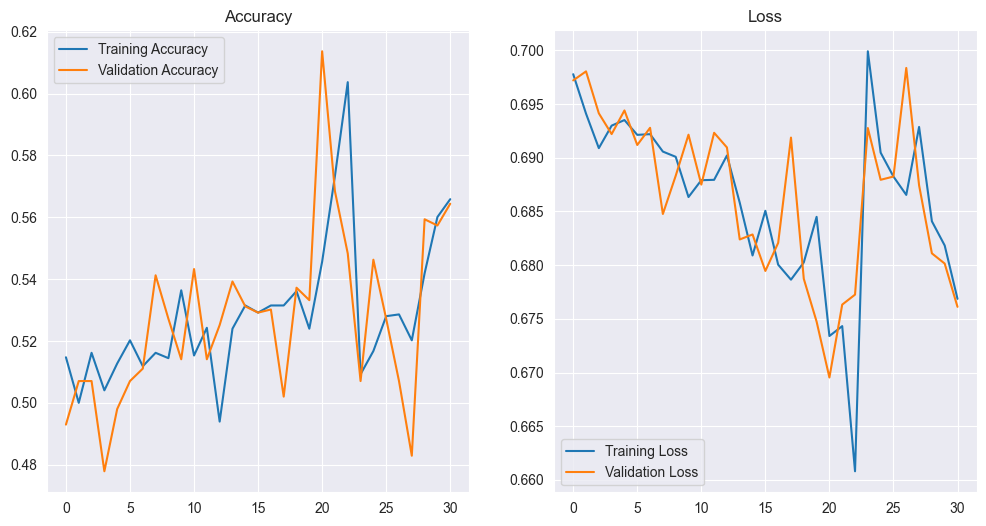

16/16 [==============================] - 0s 6ms/step


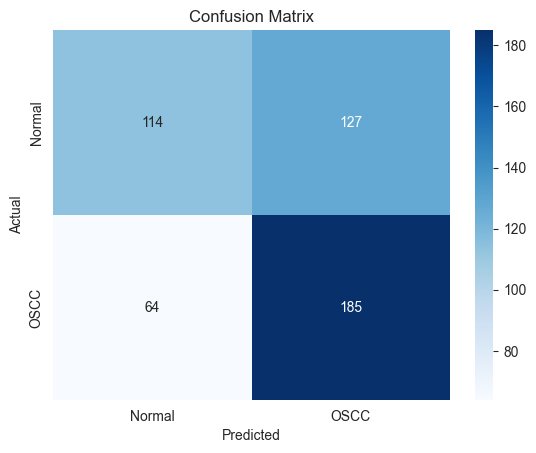

In [11]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")

Accuracy: 0.6102
Precision: 0.5929
Recall (Sensitivity): 0.7430
Specificity: 0.4730
F1 Score: 0.6595
True Positive: 185
True Negative: 114
False Positive: 127
False Negative: 64
